<a href="https://colab.research.google.com/github/cedricfoucault/scarletbutterfly/blob/master/scarletbutterfly_decoding_steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

In [6]:
#@title Data retrieval
import os, requests
import matplotlib.pyplot as plt
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [7]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

n_sessions = len(alldat)
print("n_sessions", n_sessions)

n_sessions 39


In [8]:
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [9]:
#@title Filter Trial Data
import copy
filtered_data = copy.deepcopy(alldat)

bin_size = alldat[0]['bin_size']
stim_onset = alldat[0]['stim_onset']
for i in range(len(alldat)):
  assert bin_size == alldat[i]['bin_size'], "inconsistent bin size"
  assert stim_onset == alldat[i]['stim_onset'], "inconsistent stim onset"

# Filter only the keys we are going to use
used_keys = ['spks', 'pupil', 'lfp', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'mouse_name']
for i_session in range(n_sessions):
  filtered_data[i_session] = { key: filtered_data[i_session][key] for key in used_keys }


# # Eliminate trials where contrast is > 0 and equal on both sides
array_keys = ['spks', 'pupil','lfp', 'response', 'contrast_right', 'contrast_left']



for i_session in range(n_sessions):
  session_data = filtered_data[i_session]
  equal_contrast = session_data['contrast_right'] == session_data['contrast_left']
  positive_contrast_right = session_data['contrast_right'] > 0
  should_filter = equal_contrast & positive_contrast_right

  session_data['spks'] = session_data['spks'][:,~should_filter,:]
  session_data['pupil'] = session_data['pupil'][:,~should_filter,:]
  session_data['lfp'] = session_data['lfp'][:,~should_filter,:]

  session_data['response'] = session_data['response'][~should_filter]
  session_data['contrast_right'] = session_data['contrast_right'][~should_filter]
  session_data['contrast_left'] = session_data['contrast_left'][~should_filter]

  # for key, value in session_data.items():
  #   if key in array_keys:
  #     print("key", key)
  #     print("array.shape", value.shape)
  # new_session_data = { key: array[~should_filter] for key, array in session_data.items() }
  # filtered_data[i_session] = new_session_data
  # print("session:", i_session)
  # print("original data, contrast_right:", session_data['contrast_right'])
  # print("filtered data, contrast_right:", new_session_data['contrast_right'])






{'CA1': 21, 'VISa': 5, 'SSp': 5, 'CA': 1, 'PAG': 3, 'VPL': 4, 'PL': 10, 'VISl': 3, 'SI': 1, 'MOs': 18, 'CL': 1, 'AUD': 1, 'LH': 2, 'APN': 2, 'SNr': 4, 'PIR': 1, 'MOp': 3, 'CA3': 10, 'OLF': 3, 'ACA': 11, 'NB': 1, 'ACB': 3, 'SPF': 2, 'EPd': 1, 'GPe': 3, 'root': 34, 'DG': 16, 'VISrl': 2, 'PT': 1, 'BLA': 2, 'MRN': 11, 'LSr': 4, 'MB': 6, 'SSs': 1, 'CA2': 1, 'ILA': 3, 'VISp': 12, 'VISpm': 4, 'ORBm': 1, 'POL': 3, 'RN': 1, 'LS': 3, 'MG': 2, 'MEA': 1, 'VAL': 1, 'CP': 5, 'POST': 4, 'LD': 6, 'PO': 5, 'VPM': 4, 'IC': 1, 'MS': 1, 'COA': 1, 'SUB': 9, 'DP': 1, 'SCs': 4, 'LSc': 1, 'MD': 3, 'VISam': 11, 'SCm': 7, 'SCsg': 6, 'OT': 1, 'TT': 4, 'LP': 11, 'TH': 8, 'ZI': 4, 'RT': 2, 'EP': 1, 'SCig': 4, 'LGd': 10, 'RSP': 9, 'BMA': 1, 'ORB': 5}


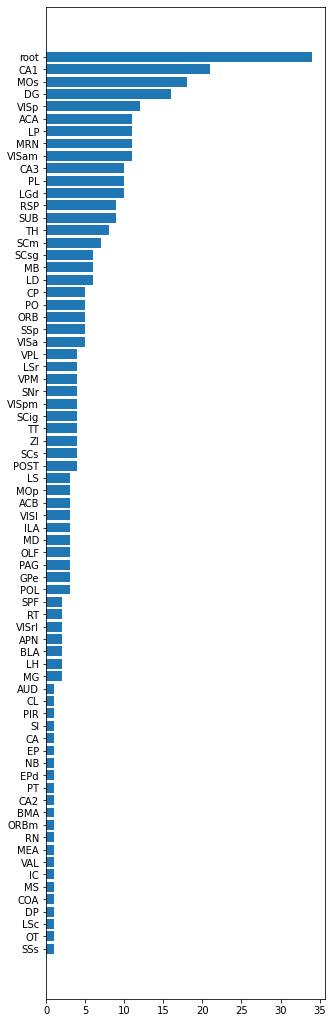

In [10]:
#Extracting brain areas:
brain_areas = set()

for i in range(n_sessions):
  brain_areas.update(filtered_data[i]['brain_area'])


#Let's focus on subcortical brain areas as they appear to experience a spike 
#Basal ganglia, midbrain
basal_ganglia = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]

count_dict = {area:0 for area in brain_areas}

for i in range(n_sessions):
  for area in set(filtered_data[i]['brain_area']):
      count_dict[area] += 1

print(count_dict)
areas = list(count_dict.keys())
count_sessions_per_areas = np.array(list(count_dict.values()))
sorted_indices = np.argsort(count_sessions_per_areas)
areas = [ areas[i] for i in sorted_indices ]
count_sessions_per_areas = count_sessions_per_areas[sorted_indices]
y_bars = np.arange(len(areas))
fig = plt.figure(figsize=(5., len(y_bars) / 4))
ax = fig.gca()
ax.barh(y_bars, count_sessions_per_areas)
ax.set_yticks(y_bars)
ax.set_yticklabels(areas)
plt.show()

In [11]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [ ]:

for i in range(n_sessions):
  plt.hist(filtered_data[i]['brain_area'])
  plt.show()

240.46153846153845
9 414.0


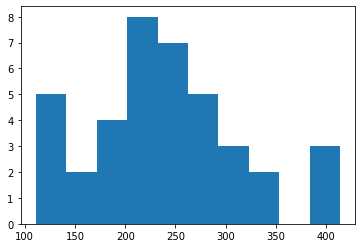

In [13]:
#Histogram of number of trials throughout the sessions
n_trials_session = np.zeros(n_sessions)
for i in range(n_sessions):
  n_trials_session[i] = len(filtered_data[i]['response'])

plt.hist(n_trials_session)
print(n_trials_session.mean())

i_session_max_trials = np.argmax(n_trials_session)
print(i_session_max_trials, n_trials_session[i_session_max_trials])

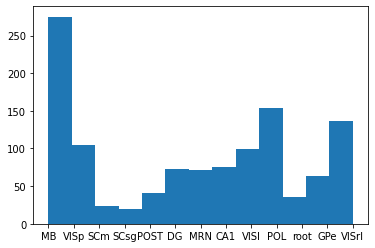

275

In [19]:
plt.hist(filtered_data[i_session_max_trials]['brain_area'],bins=13)
plt.show()
np.count_nonzero(filtered_data[i_session_max_trials]['brain_area']=='MB')

We'll focus on the session i_session_max_trials, which has the most trials and analyze the activity in the brain areas recorded during this session to try to predict the mouse's response during the trials.

In [34]:
#@title Retrieve correct (1) or incorrect (0) outcome
i_focus = i_session_max_trials
filtered_data_focus = copy.deepcopy(filtered_data[i_focus])

response = filtered_data_focus['response'] # right - nogo - left (-1, 0, 1)
vis_right = filtered_data_focus['contrast_right'] # 0 - low - high
vis_left = filtered_data_focus['contrast_left'] # 0 - low - high

# -1 : right stimulus > left stimulus
# 0: nogo trial
# 1: left stimulus > right stimulus
correct_response = np.sign(vis_left-vis_right) 

is_correct = response == correct_response
outcomes_correct = is_correct.astype(int)
print(is_correct.mean())
print(outcomes_correct)

0.6376811594202898
[0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0
 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1
 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1
 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0]


## select Mid brain region 

In [32]:
focus_brain_area='MB'
is_focus_brain_area=filtered_data_focus['brain_area']==focus_brain_area
spikes_focus=filtered_data_focus['spks'][is_focus_brain_area]
spikes_focus.shape


(275, 414, 250)

array([[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0,
        2, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0,
        1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0,
        1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1]], dtype=int8)

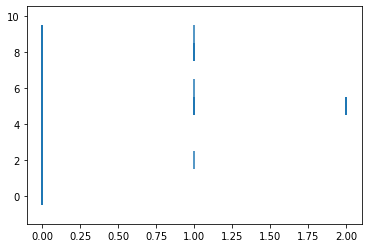

In [54]:
_=plt.eventplot(spikes_focus[20:30,2,:])
spikes_focus[25:26,2,:]

look for active neurons

In [75]:
count=0
active_trial=np.zeros(len(spikes_focus))
for i in range(len(spikes_focus)):
  count=0
  for j in range(len(spikes_focus[0,:,0])):
    if spikes_focus[i,j,:].sum()<5:
      count+=1
  active_trial[i]=len(spikes_focus[0,:,0])-count
  #print(count,'/',j+1)
print(np.count_nonzero(active_trial>20))

188


#Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
def sigmoid(z):
  """Return the logistic transform of z."""
  return 1/(1+np.exp(-z))

## Setting up the data average over the neurones

In [99]:
avg_spikes=spikes_focus.mean(axis=0)
print(avg_spikes.shape)
# outcomes_correct=>label 0 or 1
y = outcomes_correct
X = avg_spikes

(414, 250)


## Fitting the model

In [84]:
# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X, y)

y_pred = log_reg.predict(X)


In [85]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X)

  accuracy = np.count_nonzero(y_pred==y)/len(y)

  return accuracy


train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


In [92]:
accuracies = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=8) # k=8 crossvalidation
accuracies

array([0.63461538, 0.63461538, 0.63461538, 0.63461538, 0.63461538,
       0.63461538, 0.64705882, 0.64705882])

## Setting up the data average over the prestimulus time zone 

In [104]:
avg_neurones_prestimulus=spikes_focus[:,:,0:50].mean(axis=2)
y = outcomes_correct
X = avg_neurones_prestimulus.T
cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=8).mean() # k=8 crossvalidation

0.7055052790346907